In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm

plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 100})

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data = pd.read_excel("../data/Project 1_2024.xlsx", sheet_name="Data", parse_dates=["Date"], index_col="Date")

In [4]:
target = data.Balance

Посмотрим на сам ряд, а также на кумулятивную сумму

### Идея -- первоначально посмотреть на характеристики ряда, попробовать выявить внутренние стабильные признаки статистически, без разделения на трейн и тест/детекции аномалий. В дальнейшем использовать найденные закономерности для построения финальных моделей

Вообще ряд уже выглядит стационарным, наибольший интерес представляют выбросы, имеющие некоторую периодичность. 
Соответственно, стоит предположить, что они не могут быть объяснены только лишь большой дисперсией, и, вероятно, выявить их неслучайность

<Axes: xlabel='Date'>

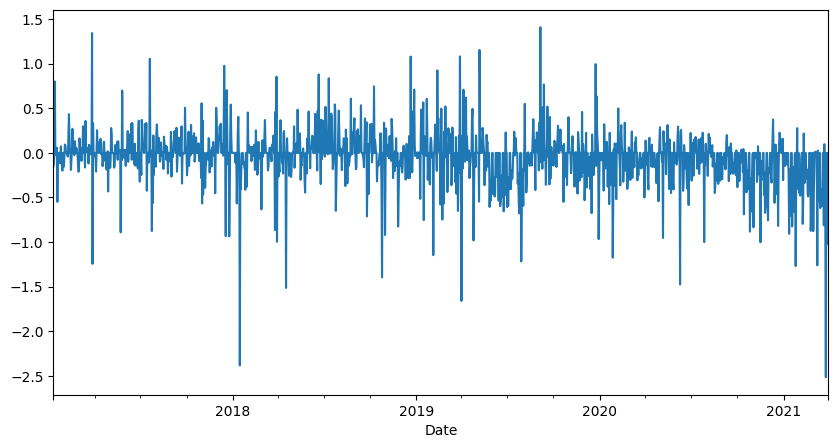

In [5]:
target.plot()

Высокая концентрация в нуле, и хвосты, несколько более тяжелые, чем характерно для нормального распределения

<Axes: >

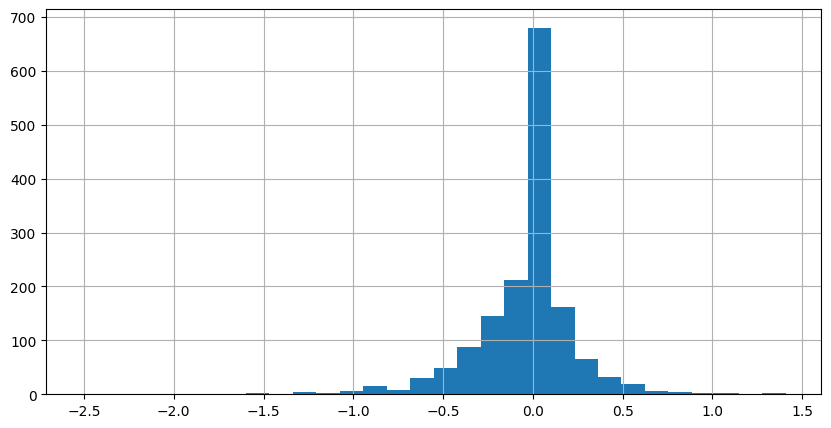

In [6]:
target.hist(bins=30)

Распределение не нормальное, но в целом мы и не сомневались, что сальдо банковского баланса -- не совсем белый шум

In [7]:
scipy.stats.normaltest(target)

NormaltestResult(statistic=532.0414230972017, pvalue=2.94220481895821e-116)

<Axes: xlabel='Date'>

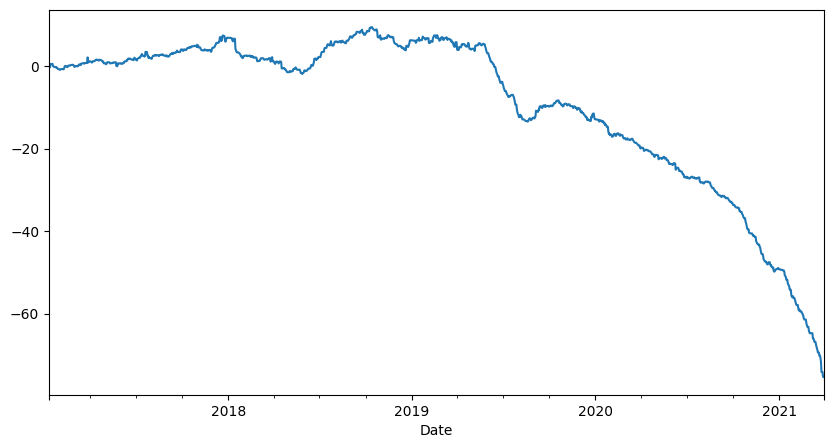

In [8]:
np.cumsum(target).plot()

##### Явная "высокочастотная" недельная сезонность, тем не менее пока нет причин предполагать гетероскедастичность. Дисперсия ряда постоянна за исключением возможных аномалий

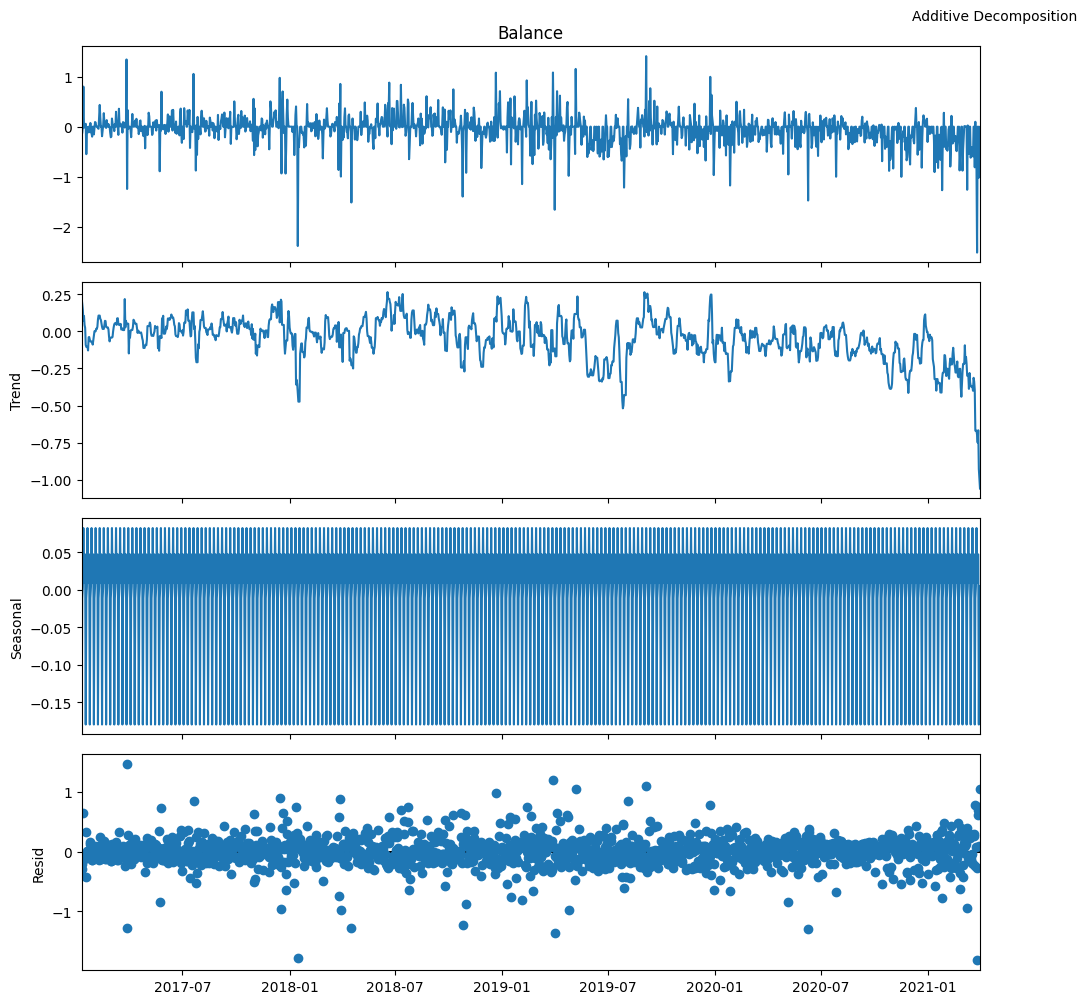

In [9]:
# Additive Decomposition
result_add = seasonal_decompose(data['Balance'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=10, position=(1, 1))
plt.show()
plt.rcParams.update({'figure.figsize': (10,5)})

Проверим стационарность (хотя в целом пока все намекает на неё при наличии сезонной компоненты и внешних факторов, объясняющих часть выбросов в ошибках)

In [10]:
result = adfuller(target, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.1141008188026875
p-value: 0.0009178315649530482
Critial Values:
   1%, -3.4346537865963596
Critial Values:
   5%, -2.8634408535813285
Critial Values:
   10%, -2.5677819879092625


Ряд стационарен

### Проверим корреляции

In [11]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #matplotlib.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scipy.stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

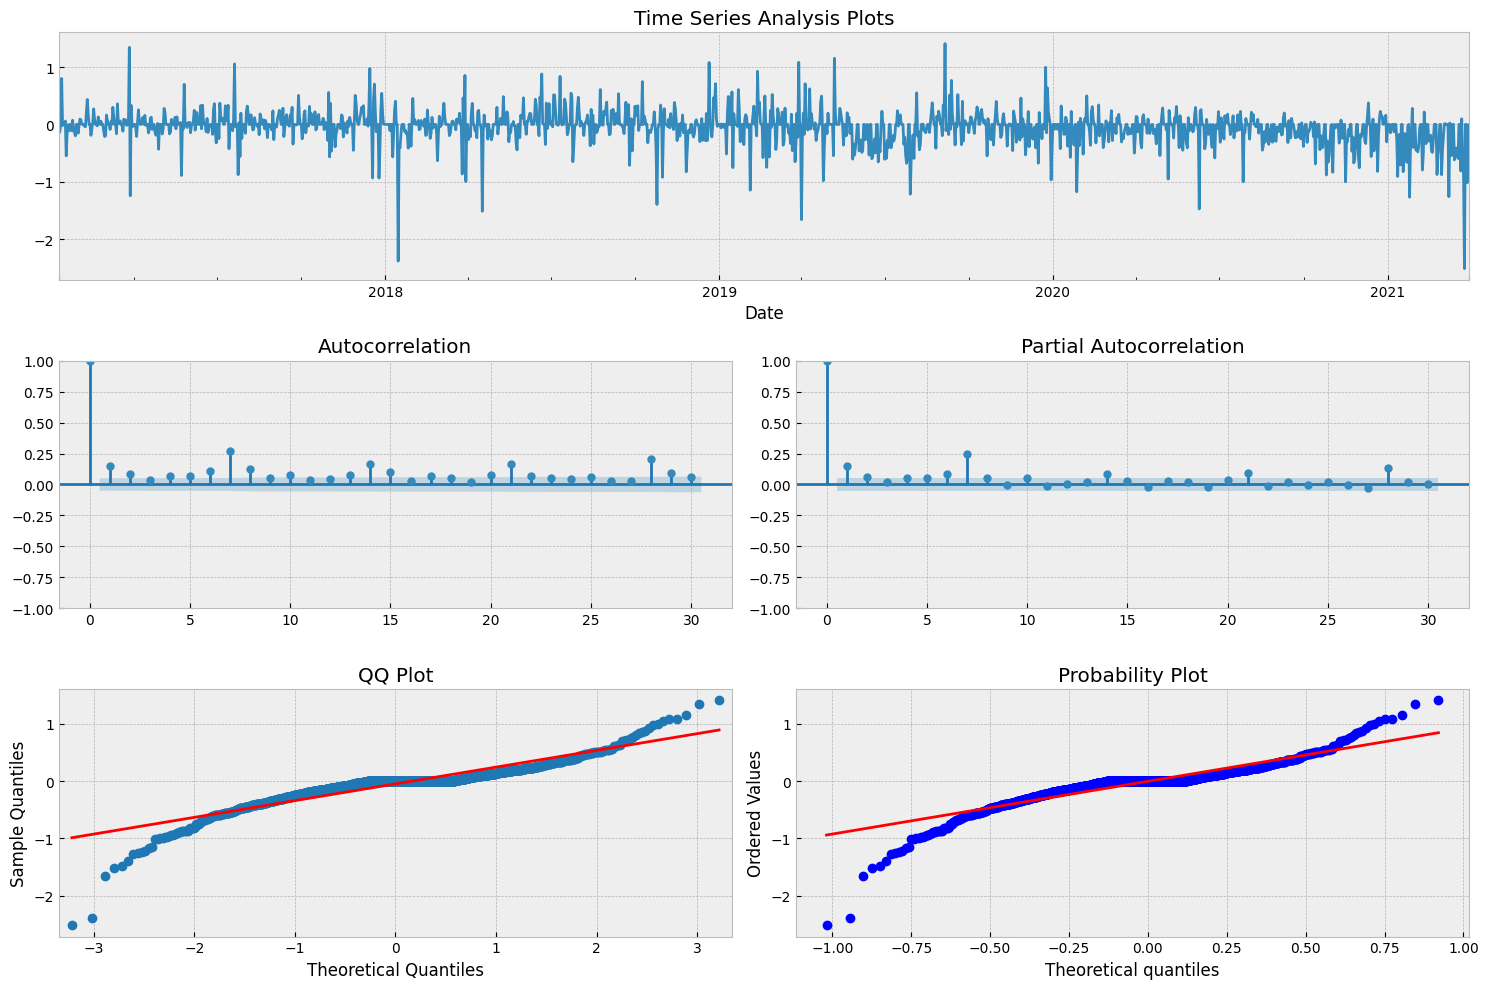

In [12]:
tsplot(target, lags=30)

#### Посмотрим на основные статистики в недельном окне, но без преобразования ряда они довольно малоинформативны

<Axes: xlabel='Date'>

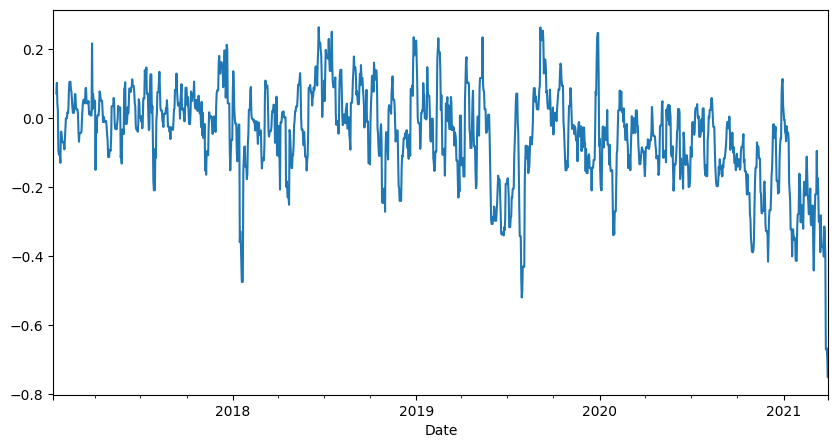

In [13]:
target.rolling(7).mean().plot()

<Axes: xlabel='Date'>

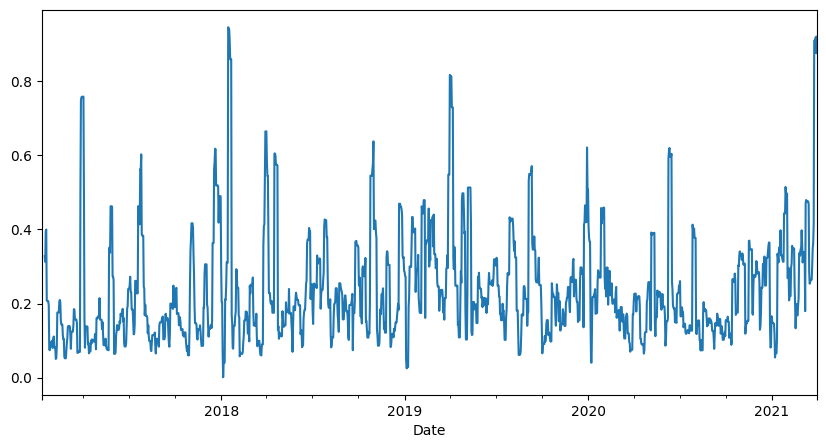

In [14]:
target.rolling(7).std().plot()

### Возьмем недельную разность

In [15]:
week_diff = (target - target.shift(7))

<Axes: xlabel='Date'>

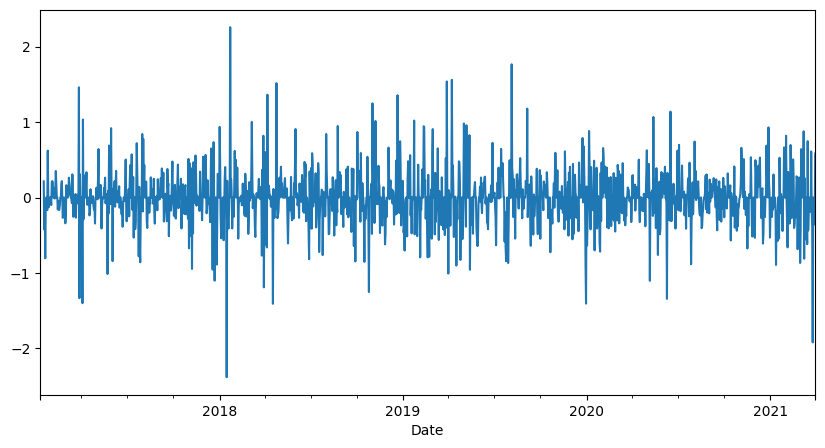

In [16]:
week_diff.plot()

### Уже существенно лучше

<Axes: xlabel='Date'>

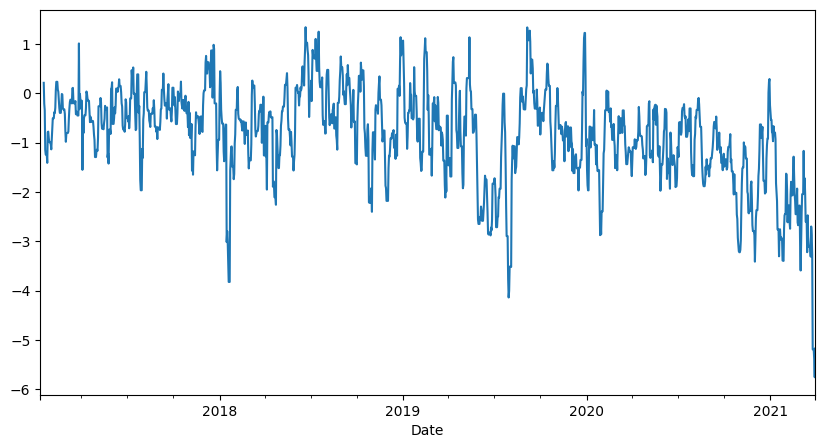

In [17]:
week_diff.cumsum().plot()

<Axes: xlabel='Date'>

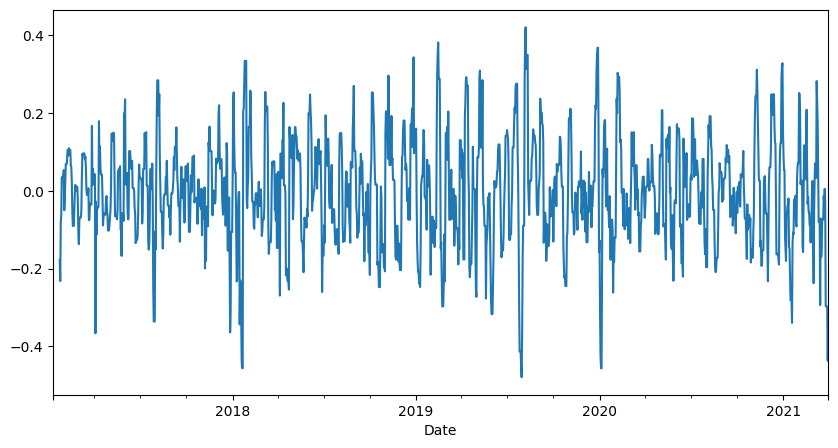

In [18]:
week_diff.rolling(7).mean().plot()

Периодичность пиков совпадает с вероятными кандидатами в аномальные значения -- будем отрабатывать их после

<Axes: xlabel='Date'>

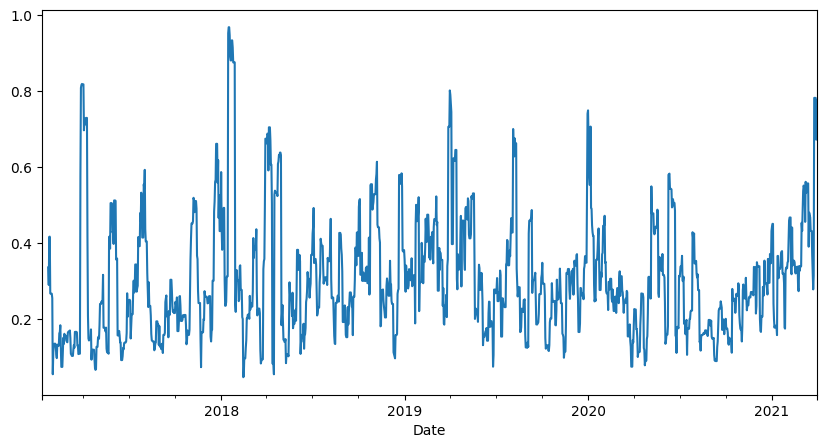

In [19]:
week_diff.rolling(7).std().plot()

In [20]:
week_diff = week_diff.dropna()

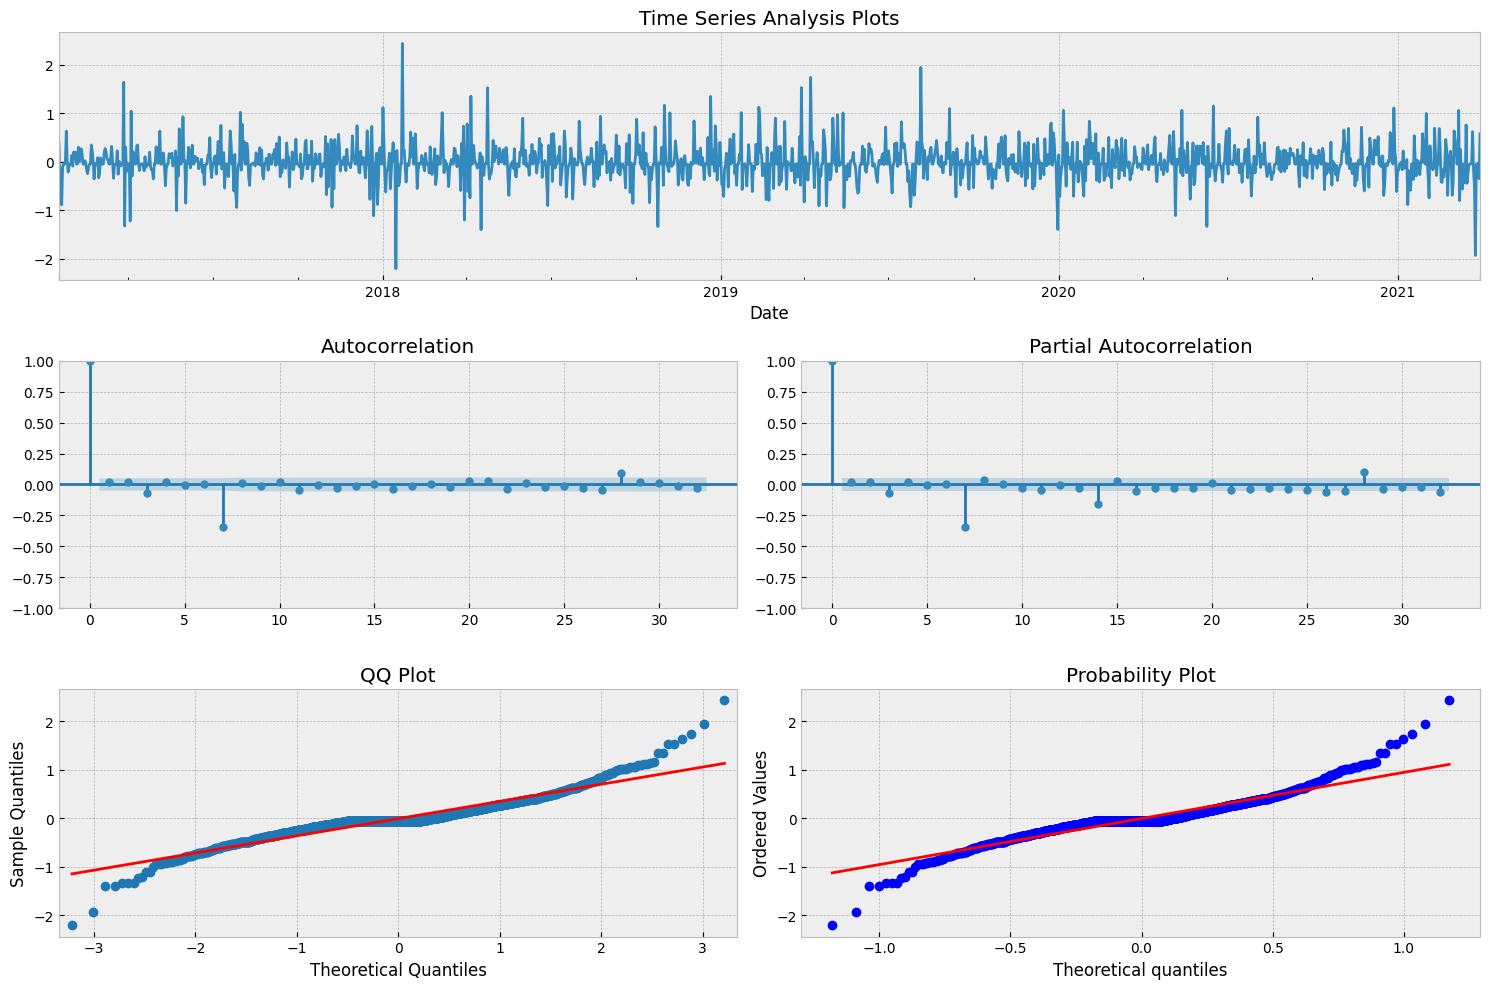

In [21]:
tsplot((week_diff - result_add.seasonal).dropna())

Проверим стационарность

In [22]:
result = adfuller(week_diff, maxlag=30, regression="ct")

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.05898392411392
p-value: 3.088356007808423e-19
Critial Values:
   1%, -3.9647859220506554
Critial Values:
   5%, -3.4134053925698042
Critial Values:
   10%, -3.1287663213703962


Протестируем равенство средних на разных частях рада

In [23]:
m = len(week_diff)/5

In [24]:
comp =  sm.stats.multicomp.MultiComparison(week_diff[:-1], groups=[i // m for i in range(len(week_diff[:-1]))])

In [25]:
results = comp.tukeyhsd()

In [26]:
results.meandiffs

array([ 0.00202048, -0.00692148,  0.00514444, -0.01149347, -0.00894195,
        0.00312396, -0.01351395,  0.01206592, -0.00457199, -0.01663791])

In [27]:
results.confint

array([[-0.07412625,  0.0781672 ],
       [-0.0830682 ,  0.06922525],
       [-0.07100228,  0.08129116],
       [-0.08770248,  0.06471554],
       [-0.08515056,  0.06726665],
       [-0.07308464,  0.07933257],
       [-0.08978479,  0.0627569 ],
       [-0.06414269,  0.08827452],
       [-0.08084284,  0.07169885],
       [-0.09290875,  0.05963293]])

In [28]:
results.pvalues

array([0.99999376, 0.99916294, 0.99974124, 0.9939663 , 0.99771973,
       0.99996457, 0.98884197, 0.99272963, 0.99983908, 0.97574229])

Ряд стационарен и не меняет общую характеристику на всем промежутке наблюдений. Тем не менее, у нас остаются необъясненные пики автокорреляции

### А если так

In [29]:
ma_week = target.rolling(7).mean()

<Axes: xlabel='Date'>

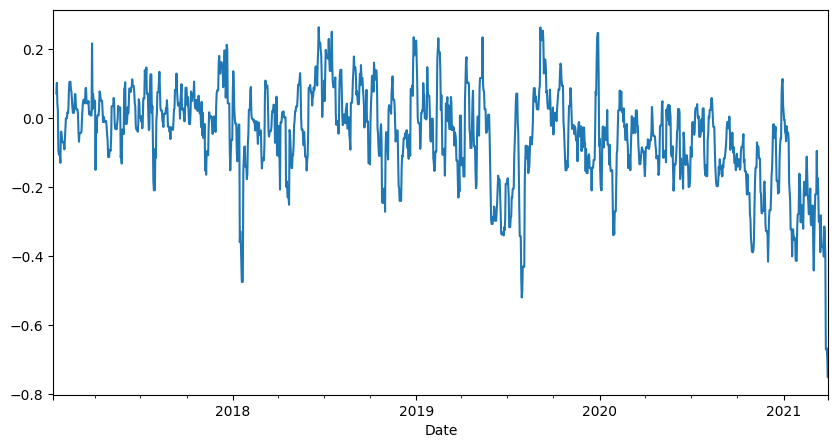

In [30]:
ma_week.plot()

<Axes: xlabel='Date'>

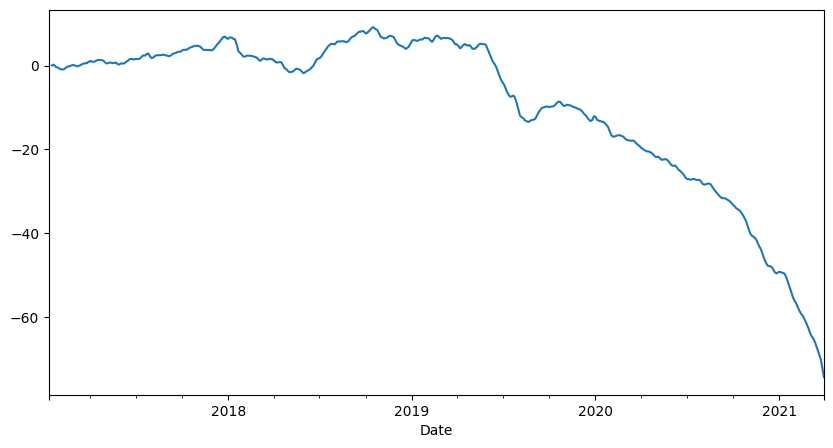

In [31]:
ma_week.cumsum().plot()

In [32]:
ma_week = ma_week.dropna()

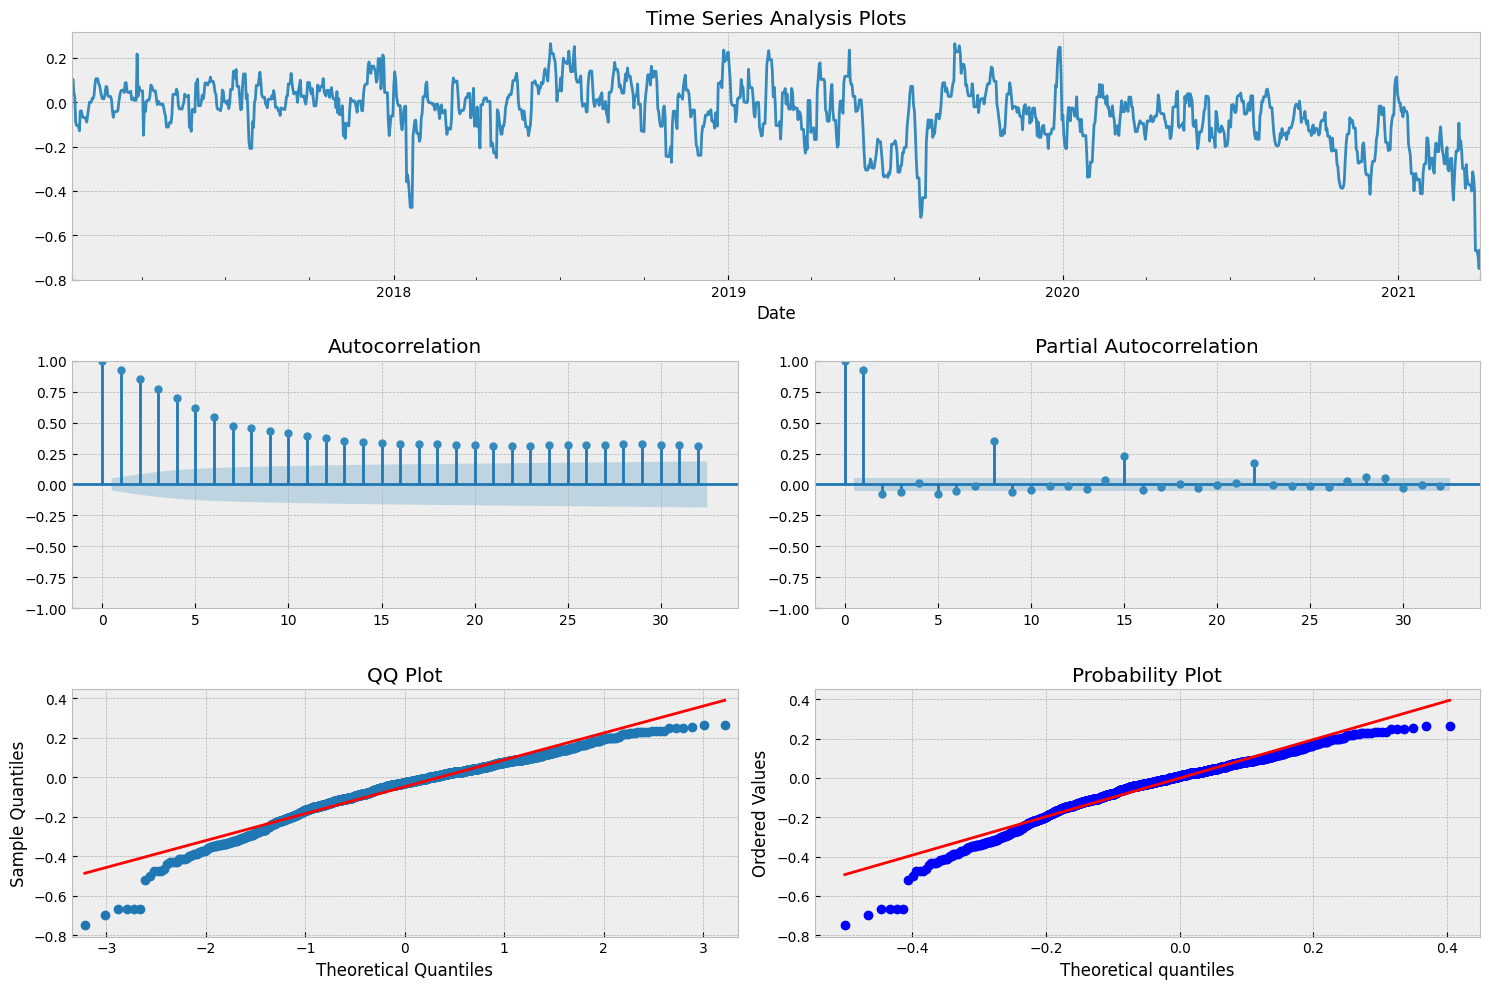

In [33]:
tsplot(ma_week,)

Тут явно хуже -- а если взять лаг, основываясь на частичной автокорреляции, придем к той же сезонной недельной разности, толку нет

### А если взять еще вторые разности с лагом в 2 недели

In [34]:
two_week_diff = (target - target.shift(14))

<Axes: xlabel='Date'>

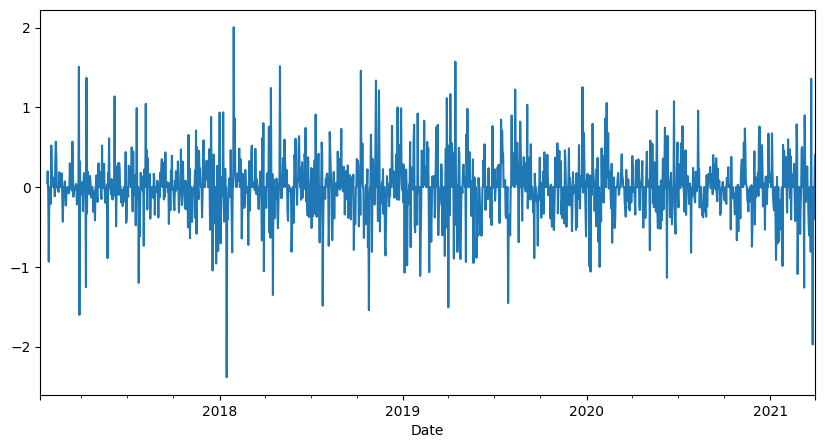

In [35]:
two_week_diff.plot()

<Axes: xlabel='Date'>

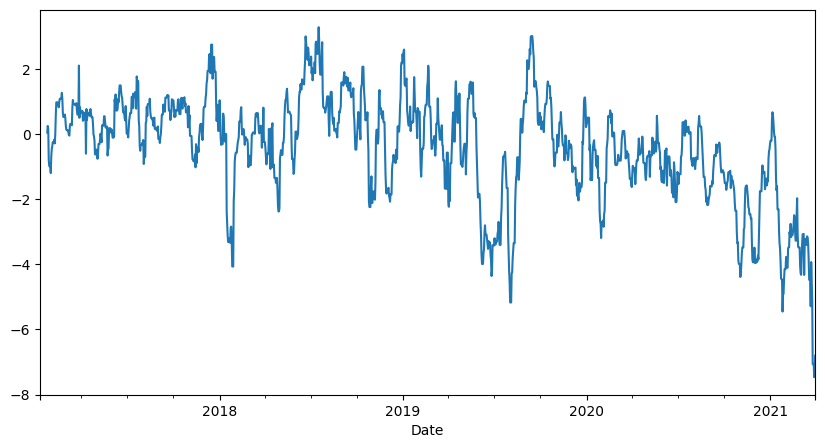

In [36]:
two_week_diff.cumsum().plot()

<Axes: xlabel='Date'>

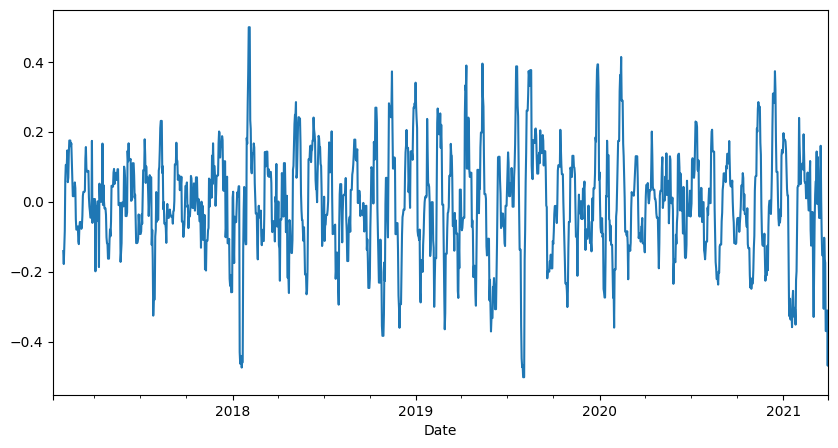

In [37]:
two_week_diff.rolling(7).mean().plot()

<Axes: xlabel='Date'>

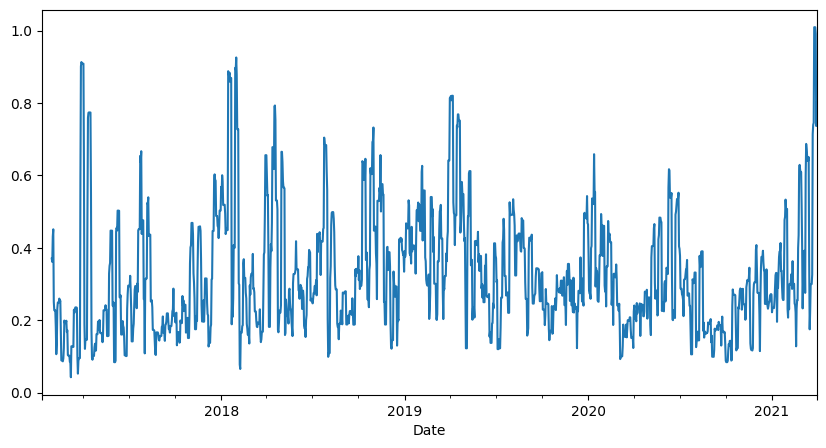

In [38]:
two_week_diff.rolling(7).std().plot()

In [39]:
two_week_diff = two_week_diff.dropna()

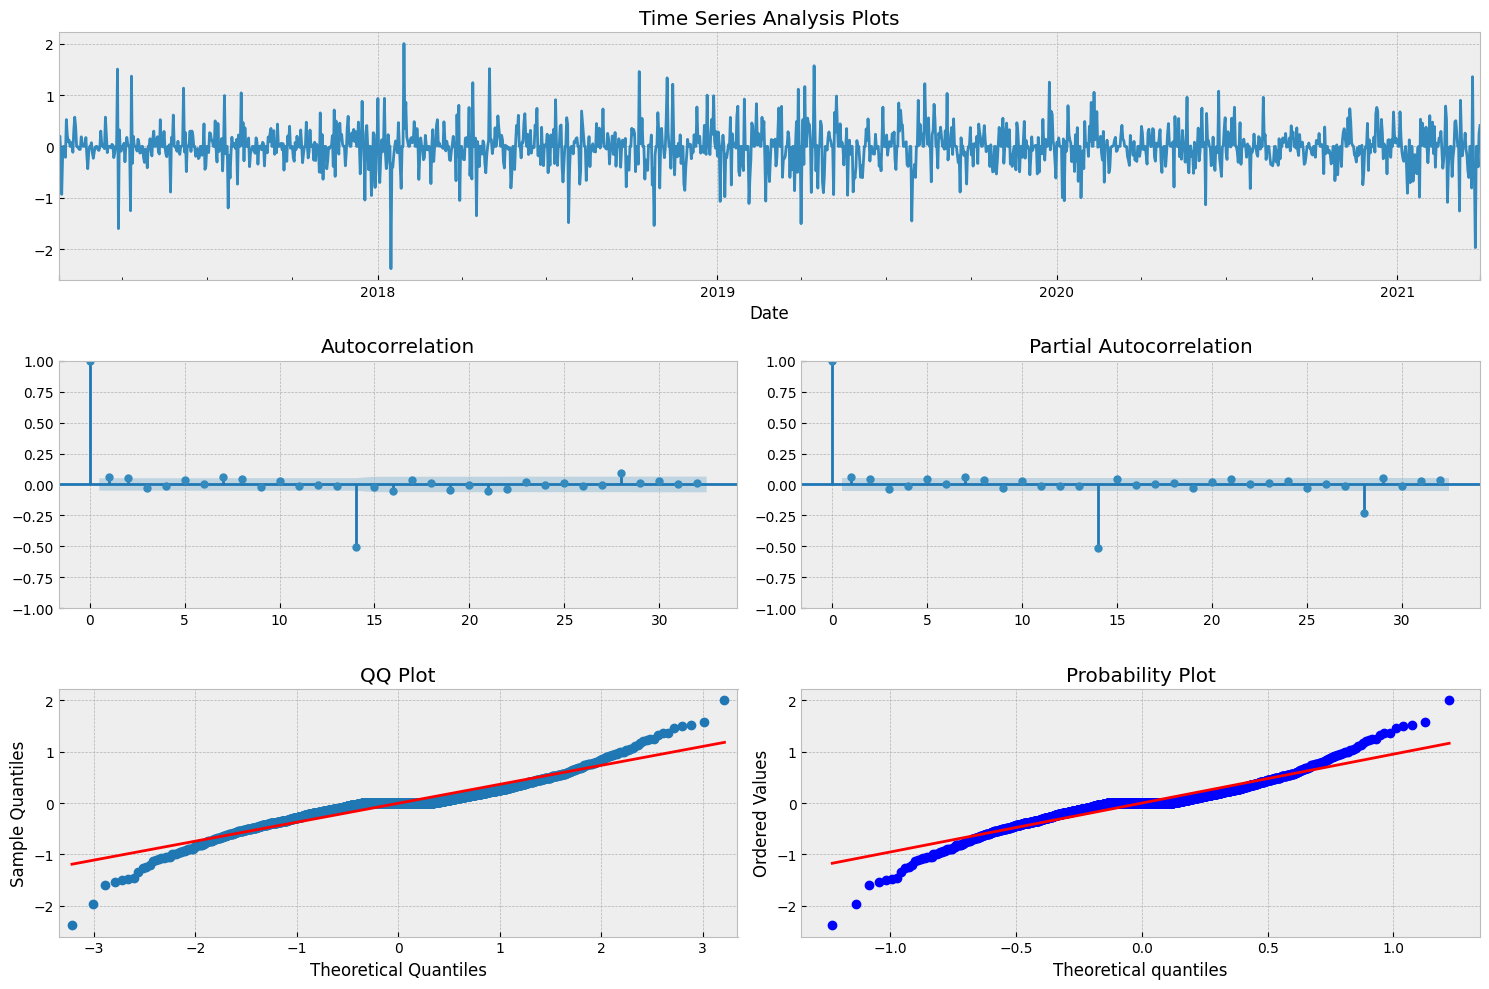

In [40]:
tsplot(two_week_diff)

Дифференцирование больше чем на один сезонный период не приносит существенных результатов, но усложняет модель -- использование не оправдано.

### Попробуем постороить модель

Возьмем первые 4 года

In [41]:
from itertools import product
import warnings

In [42]:
train = target.where(target.index.year <= 2020).dropna()

In [43]:
test = target.where(target.index.year > 2020).dropna()

Попробуем несколько вариантов, хотя, конечно, факт почти полного отсутствия автокорреляции и частичной автокорреляции после взятия сезонной разности несколько намекает, и наличие сохранившейся сезонной компоненты намекает, что причина лежит где-то вовне, и надо сразу строить SARIMAX на внешних фичах

In [44]:
ps = range(0, 2)
d = 0
qs = range(0, 2)
Ps = range(0, 2)
D = range(1, 2)
Qs = range(0, 2)



parameters = product(ps, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [45]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(target, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], param[3], param[4], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

CPU times: user 37.3 s, sys: 38 s, total: 1min 15s
Wall time: 8.14 s


In [46]:
result_table.sort_values(by="aic").head(5)

,parameters,aic
15,"(1, 1, 1, 1, 1)",336.221936
13,"(1, 1, 0, 1, 1)",349.167509
11,"(1, 0, 1, 1, 1)",349.326918
7,"(0, 1, 1, 1, 1)",350.777501
3,"(0, 0, 1, 1, 1)",361.162188


In [81]:
model = sm.tsa.SARIMAX(target, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), freq="D").fit(disp=-1)

/home/xenos/Documents/masters/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/xenos/Documents/masters/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Balance   No. Observations:                 1543
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                -163.111
Date:                           Sun, 14 Apr 2024   AIC                            336.222
Time:                                   17:11:49   BIC                            362.907
Sample:                               01-09-2017   HQIC                           346.151
                                    - 03-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9760      0.017     58.464      0.000       0.943       1.009
ma.L1         -0.9382      0.024    -38.790      0.000      -0.986      -0.891
ar.S.L7        0.1082      0.024      4.436      0.000       0.060       0.156
ma.S.L7       -0.9670      0.009   -110.383      0.000      -0.984      -0.950
sigma2         0.0716      0.001     67.638      0.000       0.070       0.074
===================================================================================
Ljung-Box (L1) (Q):                   3.42   Jarque-Bera (JB):              8124.33
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -1.13
Prob(H) (two-sided):                  0.88   Kurtosis:                        14.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотим на остатки -- несмотря на отсутствие корреляций, остатки все еще не являются нормально распределенными, и есть проблемы с хвостовыми реализациями

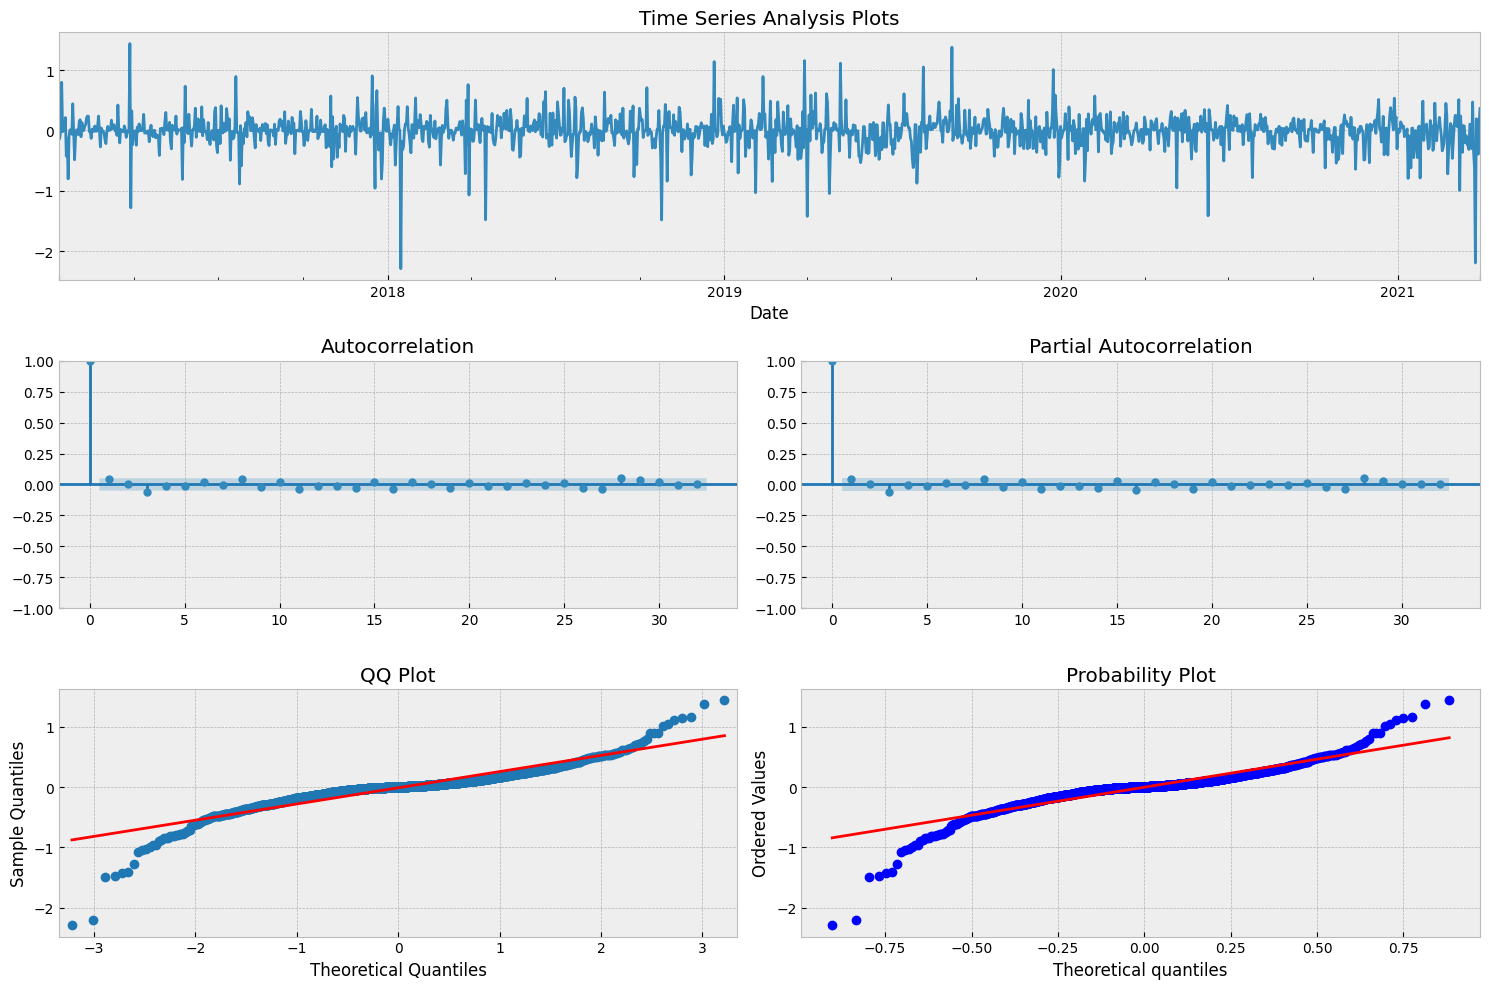

In [49]:
tsplot(model.resid)

In [50]:
result = adfuller(model.resid)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -23.577467560405893
p-value: 0.0
Critial Values:
   1%, -3.4346033983723516
Critial Values:
   5%, -2.863418614437511
Critial Values:
   10%, -2.5677701454714117


In [51]:
np.mean(model.resid)

-0.010293049965018461

In [52]:
# проблема в том, что несмотря на близкое к нулю матожидание, ошибки распределены не нормально
scipy.stats.normaltest(model.resid)

NormaltestResult(statistic=506.5134215249874, pvalue=1.028035260817992e-110)

Тем не менее, попробуем предсказать -- модель улавливает общую динамику ряда, но сильно страдает от аномалий

In [53]:
preds = model.predict(target.index[0], target.index[-1]+pd.to_timedelta(60, unit="day"))

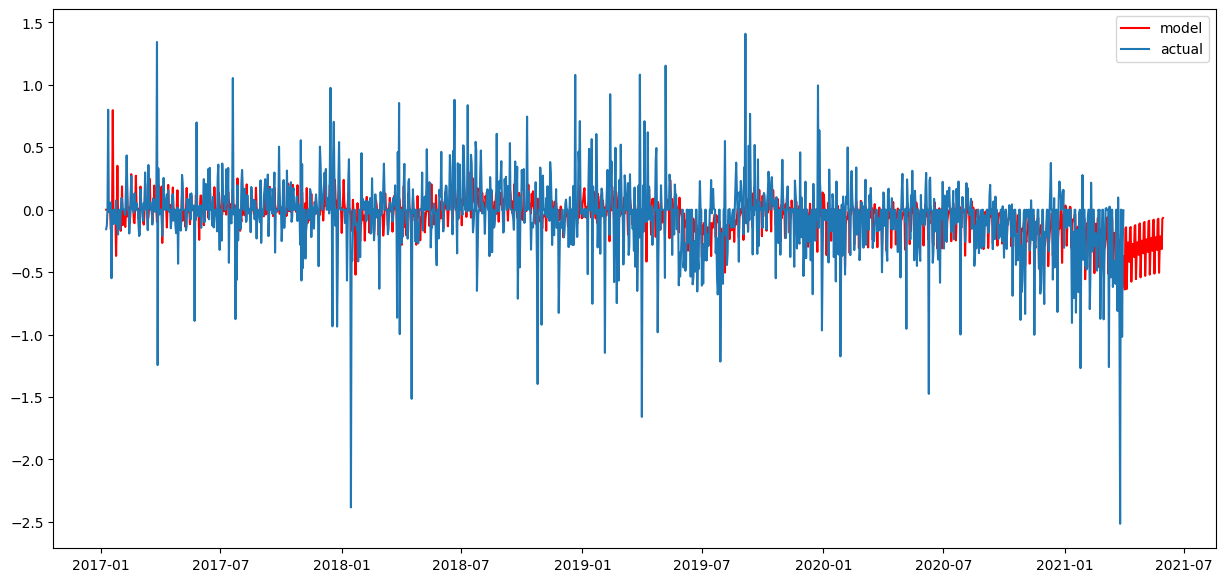

In [54]:
plt.figure(figsize=(15, 7))
plt.plot(preds, color='r', label="model")
plt.plot(target, label="actual")
plt.legend()

Довольно неважное качество

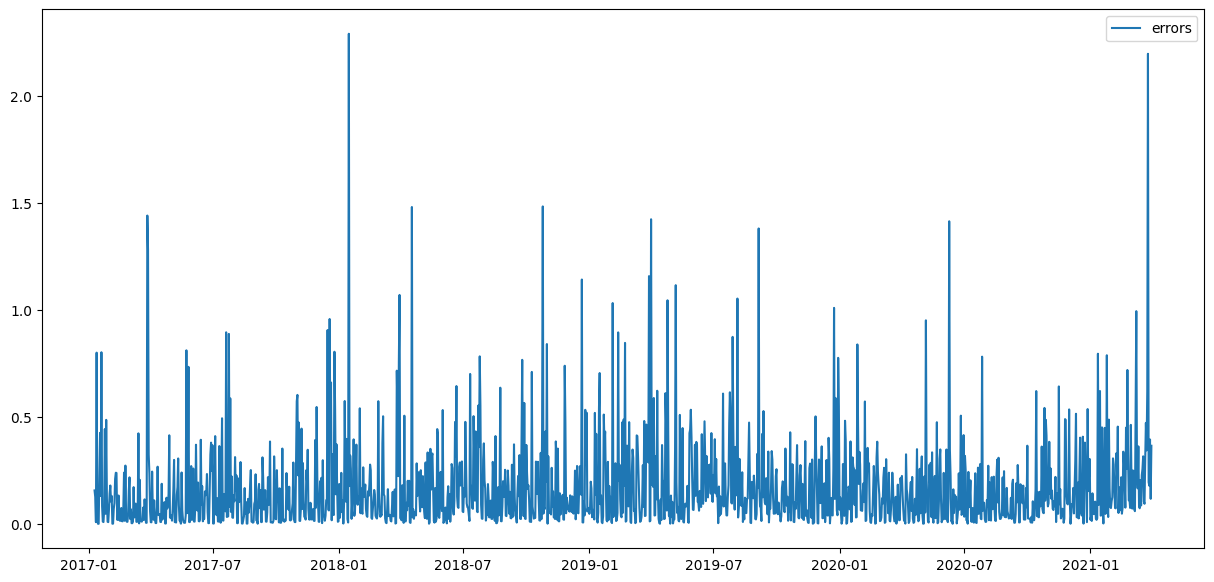

In [55]:
plt.figure(figsize=(15, 7))
plt.plot(np.abs(preds-target), label="errors")
plt.legend()

### А если докинуть линейных фичей в регрессию?

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [58]:
data = pd.read_csv("../data/featurized_dataset.csv", index_col="date", parse_dates=["date"])

In [59]:
data

,key_0,Income,Outcome,Balance,weekend,Monday,Tuesday,Wednesday,Thursday,Firday,...,median_weekly,max_weekly,min_weekly,mean_monthly,std_monthly,median_monthly,max_monthly,min_monthly,first_lag,second_lag
date,,,,,,,,,,,,,,,,,,,,,
2017-02-07,2017-02-07,0.911931,0.953220,-0.041289,0,0,1,0,0,0,...,0.000000,0.093309,-0.041289,-0.026060,0.196902,-0.002695,0.800391,-0.548519,-0.032282,0.000000
2017-02-08,2017-02-08,1.102422,0.905478,0.196944,0,0,0,1,0,0,...,0.000000,0.196944,-0.041289,-0.014298,0.199401,0.000000,0.800391,-0.548519,-0.041289,-0.032282
2017-02-09,2017-02-09,1.501032,1.071717,0.434681,0,0,0,0,1,0,...,0.000000,0.434681,-0.041289,0.004377,0.214299,0.000000,0.800391,-0.548519,0.196944,-0.041289
2017-02-10,2017-02-10,1.147702,0.964149,0.183553,0,0,0,0,0,1,...,0.000000,0.434681,-0.041289,0.010236,0.216784,0.000000,0.800391,-0.548519,0.434681,0.196944
2017-02-11,2017-02-11,0.000000,0.000000,0.000000,1,0,0,0,0,0,...,0.000000,0.434681,-0.041289,-0.016443,0.157269,0.000000,0.434681,-0.548519,0.183553,0.434681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,2021-03-27,0.000000,0.000000,0.000000,1,0,0,0,0,0,...,-0.587778,0.098041,-2.514887,-0.376162,0.537440,-0.275088,0.098041,-2.514887,-2.514887,-0.869810
2021-03-28,2021-03-28,0.000000,0.000000,0.000000,1,0,0,0,0,0,...,-0.587778,0.098041,-2.514887,-0.364302,0.541813,-0.115991,0.098041,-2.514887,0.000000,-2.514887
2021-03-29,2021-03-29,2.356883,3.370738,-1.017679,0,1,0,0,0,0,...,-0.587778,0.098041,-2.514887,-0.398224,0.550013,-0.275088,0.098041,-2.514887,0.000000,0.000000


In [60]:
train = data[data.index.year <= 2020]
test = data[data.index.year > 2020]

In [61]:
# there's only one variable with a domain not in [-1, 1]
scaler = StandardScaler()

In [62]:
scaled_keyrate_train = scaler.fit_transform(train.keyrate.to_numpy().reshape(-1, 1))

scaled_keyrate_test = scaler.transform(test.keyrate.to_numpy().reshape(-1, 1))

In [63]:
stuff = [1, 2, 3]

In [64]:
from itertools import chain, combinations

def all_subsets(some_list):
    return chain(*map(lambda x: combinations(some_list, x), range(0, len(some_list)+1)))

In [65]:
ps = range(0, 2)
d = 0
qs = range(0, 2)
Ps = range(0, 2)
D = range(1, 2)
Qs = range(0, 2)
lin_reg_params = all_subsets([train.holiday, train.preholiday, train.payday, scaled_keyrate_train])


parameters = product(ps, qs, Ps, D, Qs, lin_reg_params)
parameters_list = list(parameters)
len(parameters_list)

256

### No valid combinations of exogen parameters are integrable into the model without anomaly filtration

In [66]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train.Balance, 
                                        exog=param[5], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], param[3], param[4], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param[0:4])
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 1)
wrong pa

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

### Попробуем зафитить GARCH на остатки исходной модели

In [69]:
from arch import arch_model

Just a reminder

In [70]:
resid = model.resid
order = (1, 0, 1)
seasonal_order = (1, 1, 1, 7)

In [75]:
# скейлим на 10 для избежания ошибок, т.к. оценщик модели нестабильно работает с малыми значениями, большой роли это не играет
am = arch_model(resid*10, dist="ged")
res = am.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 41274740.41105552
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1588252.233362615
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1543298.3544783508
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3389.8665338088827
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3380.0188062765296
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3378.2029777381854
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3378.4698922000734
Iteration:      8,   Func. Count:     55,   Neg. LLF: 3377.5070035534645
Iteration:      9,   Func. Count:     61,   Neg. LLF: 3377.19116154267
Iteration:     10,   Func. Count:     67,   Neg. LLF: 3377.172555171819
Iteration:     11,   Func. Count:     73,   Neg. LLF: 3377.1676906681228
Iteration:     12,   Func. Count:     79,   Neg. LLF: 3377.16585657645
Iteration:     13,   Func. Count:     85,   Neg. LLF: 3378.225271373523
Iteration:     14,   Func. Count:     94,   Neg. LLF: 3383.

In [76]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -3377.17
Distribution:      Generalized Error Distribution   AIC:                           6764.33
Method:                        Maximum Likelihood   BIC:                           6791.04
                                                    No. Observations:                 1543
Date:                            Sun, Apr 14 2024   Df Residuals:                     1542
Time:                                    17:28:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0412      0.251      0.164      0.869 [ -0.450,  0.533]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          4.7359      0.501      9.452  3.336e-21    [  3.754,  5.718]
alpha[1]       0.1267  6.800e-02      1.863  6.252e-02 [-6.622e-03,  0.260]
beta[1]    1.8532e-11  6.141e-02  3.018e-10      1.000    [ -0.120,  0.120]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100      0.126      8.024  1.020e-15 [  0.763,  1.257]
========================================================================

Covariance estimator: robust
"""

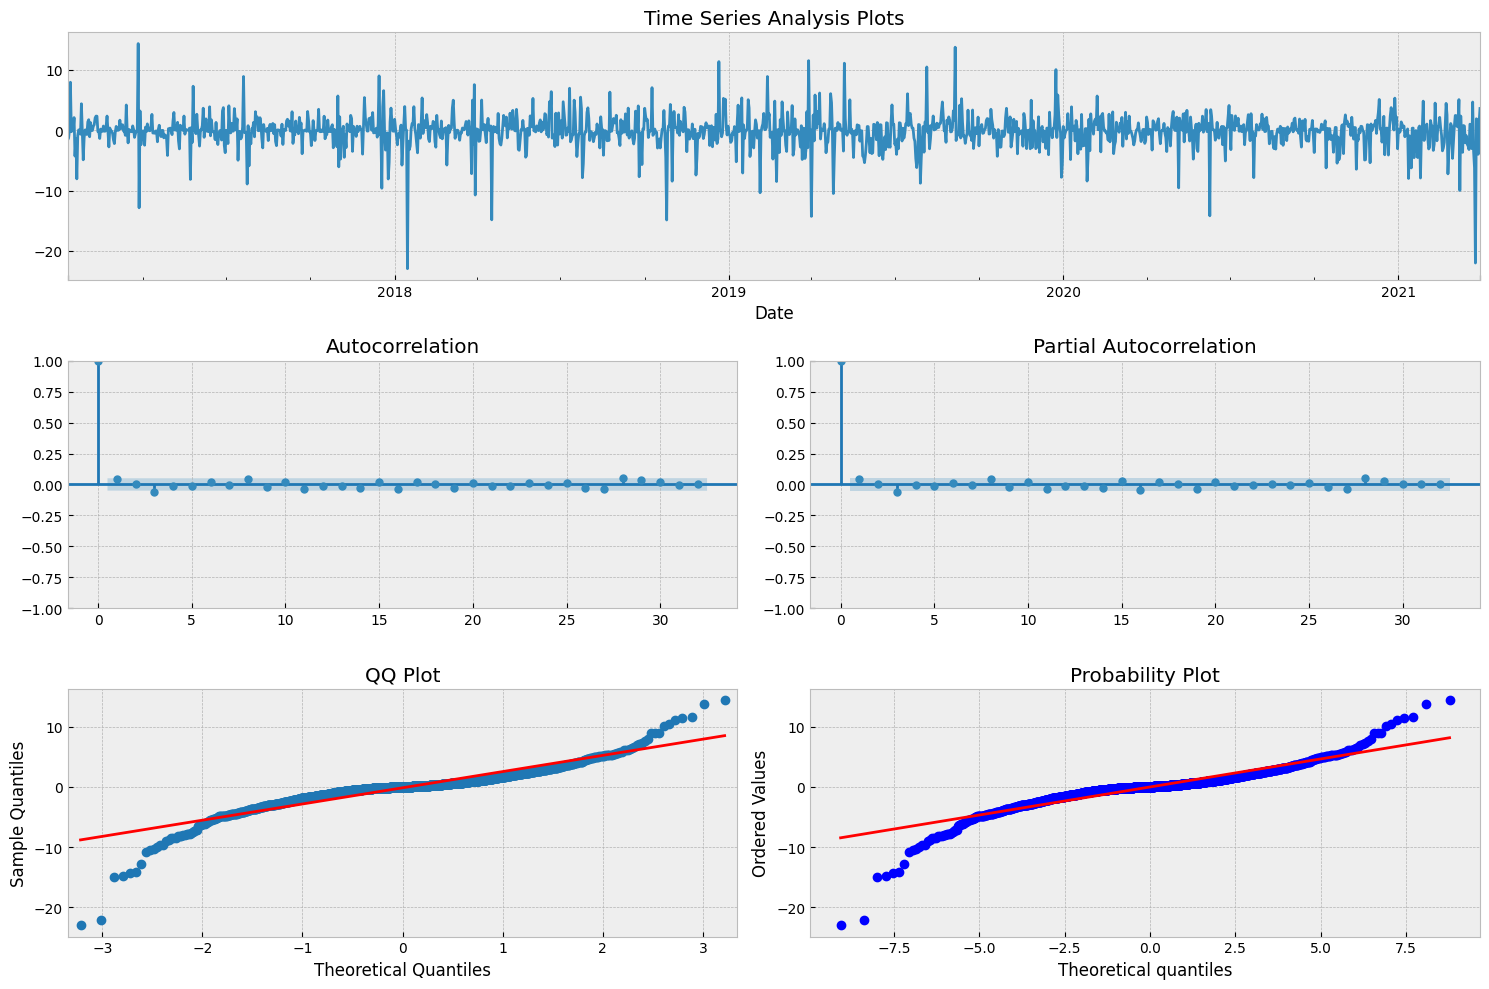

In [77]:
tsplot(res.resid)

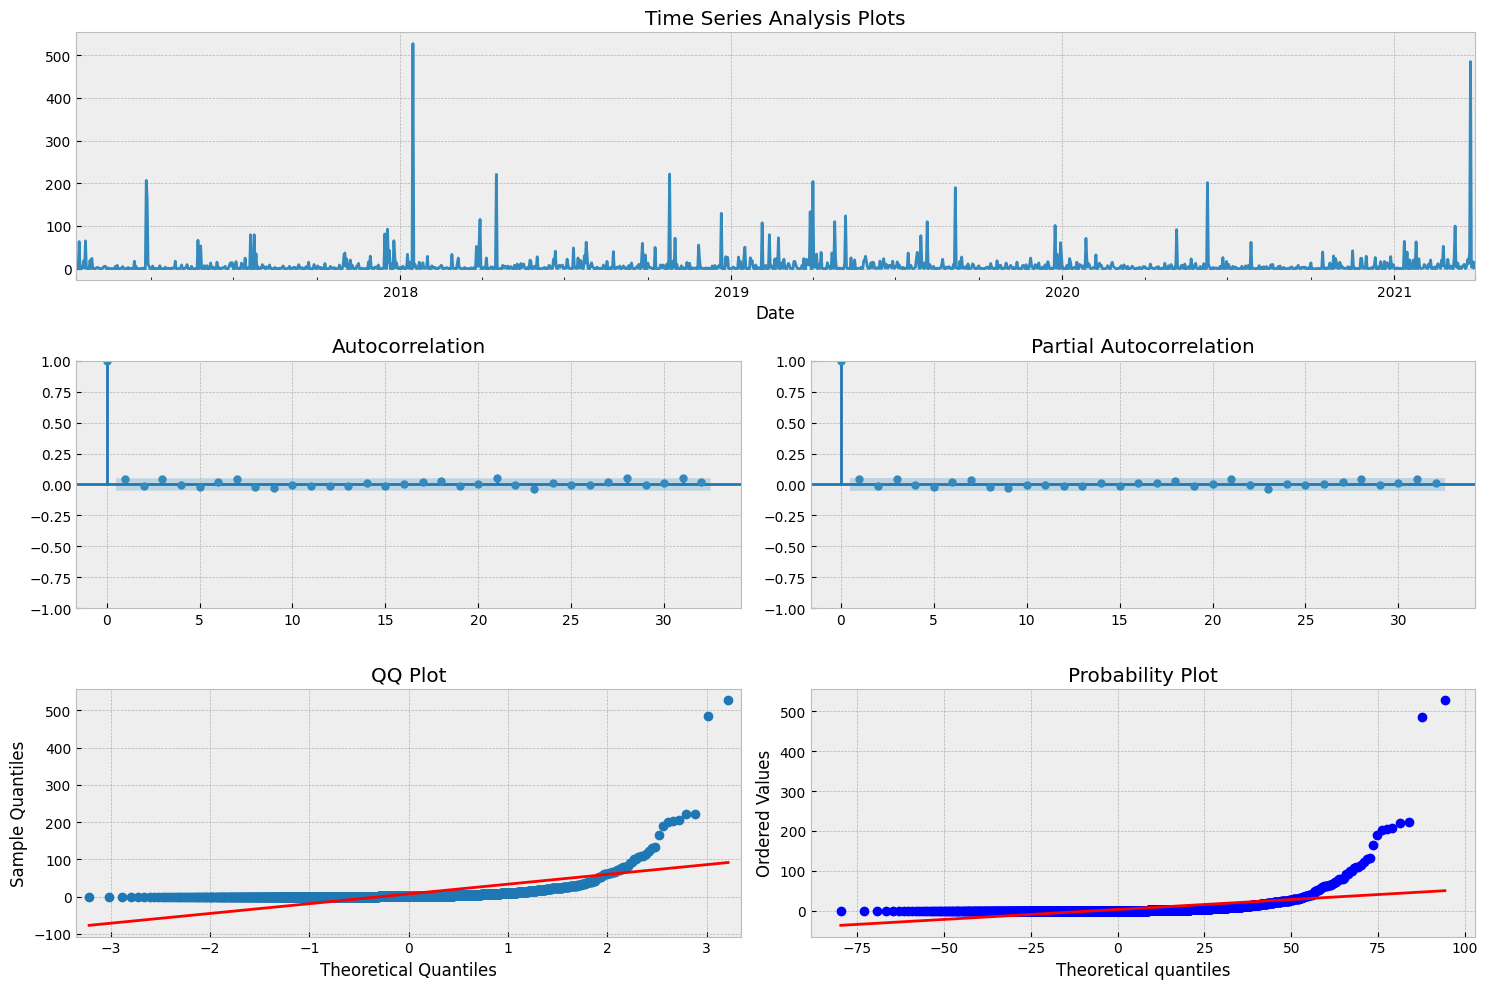

In [78]:
tsplot(res.resid**2)

Ошибки модели все еще далеки от нормальности -- надо работать с аномалиями и внешними факторами